Objective:

To predict the concrete strength using the data available in file concrete_data.xls. 
Apply feature engineering and model tuning to obtain 80% to 95% of R2score.

Attribute Information:
Given are the variable name, variable type, the measurement unit and a brief description.
The concrete compressive strength is the regression problem. The order of this listing
corresponds to the order of numerals along the rows of the database.


Name -- Data Type -- Measurement -- Description
 Cement (cement) -- quantitative -- kg in a m3 mixture -- Input Variable
 Blast Furnace Slag (slag) -- quantitative -- kg in a m3 mixture -- Input Variable
 Fly Ash (ash) -- quantitative -- kg in a m3 mixture -- Input Variable
 Water (water) -- quantitative -- kg in a m3 mixture -- Input Variable
 Superplasticizer (superplastic) -- quantitative -- kg in a m3 mixture -- Input Variable
 Coarse Aggregate (coarseagg) -- quantitative -- kg in a m3 mixture -- Input Variable
 Fine Aggregate (fineagg) -- quantitative -- kg in a m3 mixture -- Input Variable
 Age(age) -- quantitative -- Day (1~365) -- Input Variable
 Concrete compressive strength(strength) -- quantitative -- MPa -- Output Variable

Step 1:
Download all necessary libraries. Download the file. Perform univariate analysis –data types and description of the independent attributes which should include (name, range of values observed, central values (mean and median), standard deviation and quartiles, analysis of the body of distributions / tails, missing values, outliers, duplicates.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
# Import stats from scipy
from scipy import stats
# Import zscore for scaling
from scipy.stats import zscore
from sklearn import metrics
%matplotlib inline

In [2]:
df = pd.read_csv("concrete.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [4]:
##Look for NULL values
df.isnull().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

In [5]:

col_names = ["cement","slag","ash","water","superplastic","coarseagg","fineagg","age","strength"]
df.columns = col_names

In [6]:
##DQ check (age of cement should be within 1 to 365 days) as per definition:

df[df['age'] > 365]

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength


In [7]:
df[df['age'] < 1]

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength


In [8]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [9]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


Observations:
1) Slag, ash and superplastic have 0 values, will probably need to be replaced as they cannot be right.
2) Slag, ash and age have big difference between meand and 50% percentile with mean being larger than 50% percentile
indicating right tail skew.
3) Slag, ash and age have wide difference between Q1, mean and Q3 indicating outliers

In [10]:
##Finding outliers for Cement:
Q1=df['cement'].quantile(q=0.25)
Q3=df['cement'].quantile(q=0.75)
print('1st Quartile (Q1) is: ', Q1)
print('3st Quartile (Q3) is: ', Q3)
print('Interquartile range (IQR) is ', stats.iqr(df['cement']))
L_outliers=Q1-1.5*(Q3-Q1)
U_outliers=Q3+1.5*(Q3-Q1)
print('Lower outliers in cement: ', L_outliers)
print('Upper outliers in cement: ', U_outliers)

print('Number of outliers in cement upper : ', df[df['cement']>U_outliers]['cement'].count())
print('Number of outliers in cement lower : ', df[df['cement']<L_outliers]['cement'].count())
print('% of Outlier in cement upper: ',round(df[df['cement']>U_outliers]['cement'].count()*100/len(df)), '%')
print('% of Outlier in cement lower: ',round(df[df['cement']<L_outliers]['cement'].count()*100/len(df)), '%')

1st Quartile (Q1) is:  192.375
3st Quartile (Q3) is:  350.0
Interquartile range (IQR) is  157.625
Lower outliers in cement:  -44.0625
Upper outliers in cement:  586.4375
Number of outliers in cement upper :  0
Number of outliers in cement lower :  0
% of Outlier in cement upper:  0.0 %
% of Outlier in cement lower:  0.0 %


In [11]:
##Finding outliers for Slag:
Q1=df['slag'].quantile(q=0.25)
Q3=df['slag'].quantile(q=0.75)
print('1st Quartile (Q1) is: ', Q1)
print('3st Quartile (Q3) is: ', Q3)
print('Interquartile range (IQR) is ', stats.iqr(df['slag']))
L_outliers=Q1-1.5*(Q3-Q1)
U_outliers=Q3+1.5*(Q3-Q1)
print('Lower outliers in slag: ', L_outliers)
print('Upper outliers in slag: ', U_outliers)

print('Number of outliers in slag upper : ', df[df['slag']>U_outliers]['slag'].count())
print('Number of outliers in slag lower : ', df[df['slag']<L_outliers]['slag'].count())
print('% of Outlier in slag upper: ',round(df[df['slag']>U_outliers]['slag'].count()*100/len(df)), '%')
print('% of Outlier in slag lower: ',round(df[df['slag']<L_outliers]['slag'].count()*100/len(df)), '%')


1st Quartile (Q1) is:  0.0
3st Quartile (Q3) is:  142.95
Interquartile range (IQR) is  142.95
Lower outliers in slag:  -214.42499999999998
Upper outliers in slag:  357.375
Number of outliers in slag upper :  2
Number of outliers in slag lower :  0
% of Outlier in slag upper:  0.0 %
% of Outlier in slag lower:  0.0 %


In [12]:
##Finding outliers for Ash:
Q1=df['ash'].quantile(q=0.25)
Q3=df['ash'].quantile(q=0.75)
print('1st Quartile (Q1) is: ', Q1)
print('3st Quartile (Q3) is: ', Q3)
print('Interquartile range (IQR) is ', stats.iqr(df['ash']))
L_outliers=Q1-1.5*(Q3-Q1)
U_outliers=Q3+1.5*(Q3-Q1)
print('Lower outliers in ash: ', L_outliers)
print('Upper outliers in ash: ', U_outliers)

print('Number of outliers in ash upper : ', df[df['ash']>U_outliers]['ash'].count())
print('Number of outliers in ash lower : ', df[df['ash']<L_outliers]['ash'].count())
print('% of Outlier in ash upper: ',round(df[df['ash']>U_outliers]['ash'].count()*100/len(df)), '%')
print('% of Outlier in ash lower: ',round(df[df['ash']<L_outliers]['ash'].count()*100/len(df)), '%')


1st Quartile (Q1) is:  0.0
3st Quartile (Q3) is:  118.3
Interquartile range (IQR) is  118.3
Lower outliers in ash:  -177.45
Upper outliers in ash:  295.75
Number of outliers in ash upper :  0
Number of outliers in ash lower :  0
% of Outlier in ash upper:  0.0 %
% of Outlier in ash lower:  0.0 %


In [13]:
##Finding outliers for Water:
Q1=df['water'].quantile(q=0.25)
Q3=df['water'].quantile(q=0.75)
print('1st Quartile (Q1) is: ', Q1)
print('3st Quartile (Q3) is: ', Q3)
print('Interquartile range (IQR) is ', stats.iqr(df['water']))
L_outliers=Q1-1.5*(Q3-Q1)
U_outliers=Q3+1.5*(Q3-Q1)
print('Lower outliers in water: ', L_outliers)
print('Upper outliers in water: ', U_outliers)

print('Number of outliers in water upper : ', df[df['water']>U_outliers]['water'].count())
print('Number of outliers in water lower : ', df[df['water']<L_outliers]['water'].count())
print('% of Outlier in water upper: ',round(df[df['water']>U_outliers]['water'].count()*100/len(df)), '%')
print('% of Outlier in water lower: ',round(df[df['water']<L_outliers]['water'].count()*100/len(df)), '%')


1st Quartile (Q1) is:  164.9
3st Quartile (Q3) is:  192.0
Interquartile range (IQR) is  27.099999999999994
Lower outliers in water:  124.25000000000001
Upper outliers in water:  232.64999999999998
Number of outliers in water upper :  4
Number of outliers in water lower :  5
% of Outlier in water upper:  0.0 %
% of Outlier in water lower:  0.0 %


In [14]:
##Finding outliers for Superplastic:
Q1=df['superplastic'].quantile(q=0.25)
Q3=df['superplastic'].quantile(q=0.75)
print('1st Quartile (Q1) is: ', Q1)
print('3st Quartile (Q3) is: ', Q3)
print('Interquartile range (IQR) is ', stats.iqr(df['superplastic']))
L_outliers=Q1-1.5*(Q3-Q1)
U_outliers=Q3+1.5*(Q3-Q1)
print('Lower outliers in superplastic: ', L_outliers)
print('Upper outliers in superplastic: ', U_outliers)

print('Number of outliers in superplastic upper : ', df[df['superplastic']>U_outliers]['superplastic'].count())
print('Number of outliers in superplastic lower : ', df[df['superplastic']<L_outliers]['superplastic'].count())
print('% of Outlier in superplastic upper: ',round(df[df['superplastic']>U_outliers]['superplastic'].count()*100/len(df)), '%')
print('% of Outlier in superplastic lower: ',round(df[df['superplastic']<L_outliers]['superplastic'].count()*100/len(df)), '%')


1st Quartile (Q1) is:  0.0
3st Quartile (Q3) is:  10.2
Interquartile range (IQR) is  10.2
Lower outliers in superplastic:  -15.299999999999999
Upper outliers in superplastic:  25.5
Number of outliers in superplastic upper :  10
Number of outliers in superplastic lower :  0
% of Outlier in superplastic upper:  1.0 %
% of Outlier in superplastic lower:  0.0 %


In [15]:
##Finding outliers for Coarseagg:
Q1=df['coarseagg'].quantile(q=0.25)
Q3=df['coarseagg'].quantile(q=0.75)
print('1st Quartile (Q1) is: ', Q1)
print('3st Quartile (Q3) is: ', Q3)
print('Interquartile range (IQR) is ', stats.iqr(df['coarseagg']))
L_outliers=Q1-1.5*(Q3-Q1)
U_outliers=Q3+1.5*(Q3-Q1)
print('Lower outliers in coarseagg: ', L_outliers)
print('Upper outliers in coarseagg: ', U_outliers)

print('Number of outliers in coarseagg upper : ', df[df['coarseagg']>U_outliers]['coarseagg'].count())
print('Number of outliers in coarseagg lower : ', df[df['coarseagg']<L_outliers]['coarseagg'].count())
print('% of Outlier in coarseagg upper: ',round(df[df['coarseagg']>U_outliers]['coarseagg'].count()*100/len(df)), '%')
print('% of Outlier in coarseagg lower: ',round(df[df['coarseagg']<L_outliers]['coarseagg'].count()*100/len(df)), '%')


1st Quartile (Q1) is:  932.0
3st Quartile (Q3) is:  1029.4
Interquartile range (IQR) is  97.40000000000009
Lower outliers in coarseagg:  785.8999999999999
Upper outliers in coarseagg:  1175.5000000000002
Number of outliers in coarseagg upper :  0
Number of outliers in coarseagg lower :  0
% of Outlier in coarseagg upper:  0.0 %
% of Outlier in coarseagg lower:  0.0 %


In [16]:
##Finding outliers for Fineagg:
Q1=df['fineagg'].quantile(q=0.25)
Q3=df['fineagg'].quantile(q=0.75)
print('1st Quartile (Q1) is: ', Q1)
print('3st Quartile (Q3) is: ', Q3)
print('Interquartile range (IQR) is ', stats.iqr(df['fineagg']))
L_outliers=Q1-1.5*(Q3-Q1)
U_outliers=Q3+1.5*(Q3-Q1)
print('Lower outliers in fineagg: ', L_outliers)
print('Upper outliers in fineagg: ', U_outliers)

print('Number of outliers in fineagg upper : ', df[df['fineagg']>U_outliers]['fineagg'].count())
print('Number of outliers in fineagg lower : ', df[df['fineagg']<L_outliers]['fineagg'].count())
print('% of Outlier in fineagg upper: ',round(df[df['fineagg']>U_outliers]['fineagg'].count()*100/len(df)), '%')
print('% of Outlier in fineagg lower: ',round(df[df['fineagg']<L_outliers]['fineagg'].count()*100/len(df)), '%')


1st Quartile (Q1) is:  730.9499999999999
3st Quartile (Q3) is:  824.0
Interquartile range (IQR) is  93.05000000000007
Lower outliers in fineagg:  591.3749999999998
Upper outliers in fineagg:  963.575
Number of outliers in fineagg upper :  5
Number of outliers in fineagg lower :  0
% of Outlier in fineagg upper:  0.0 %
% of Outlier in fineagg lower:  0.0 %


In [17]:
##Finding outliers for Age:
Q1=df['age'].quantile(q=0.25)
Q3=df['age'].quantile(q=0.75)
print('1st Quartile (Q1) is: ', Q1)
print('3st Quartile (Q3) is: ', Q3)
print('Interquartile range (IQR) is ', stats.iqr(df['age']))
L_outliers=Q1-1.5*(Q3-Q1)
U_outliers=Q3+1.5*(Q3-Q1)
print('Lower outliers in age: ', L_outliers)
print('Upper outliers in age: ', U_outliers)

print('Number of outliers in age upper : ', df[df['age']>U_outliers]['age'].count())
print('Number of outliers in age lower : ', df[df['age']<L_outliers]['age'].count())
print('% of Outlier in age upper: ',round(df[df['age']>U_outliers]['age'].count()*100/len(df)), '%')
print('% of Outlier in age lower: ',round(df[df['age']<L_outliers]['age'].count()*100/len(df)), '%')


1st Quartile (Q1) is:  7.0
3st Quartile (Q3) is:  56.0
Interquartile range (IQR) is  49.0
Lower outliers in age:  -66.5
Upper outliers in age:  129.5
Number of outliers in age upper :  59
Number of outliers in age lower :  0
% of Outlier in age upper:  6.0 %
% of Outlier in age lower:  0.0 %


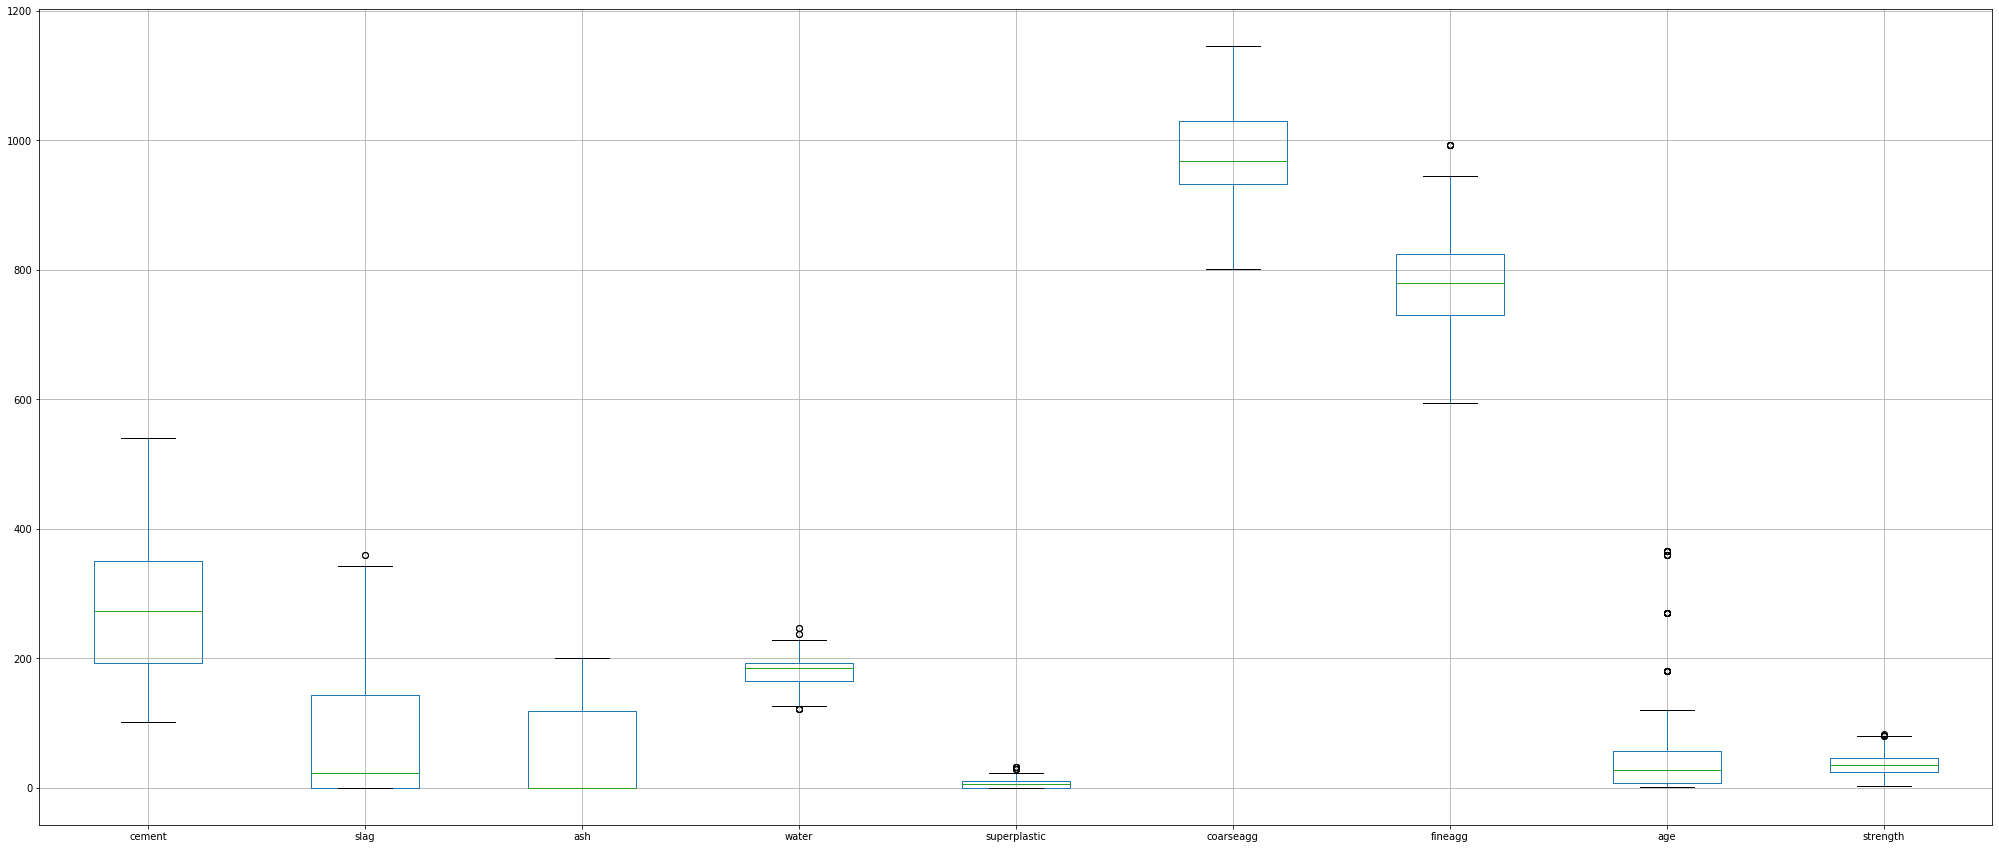

In [18]:
##Replace outliers with median:
##Before:
df.boxplot(figsize=(35,15))

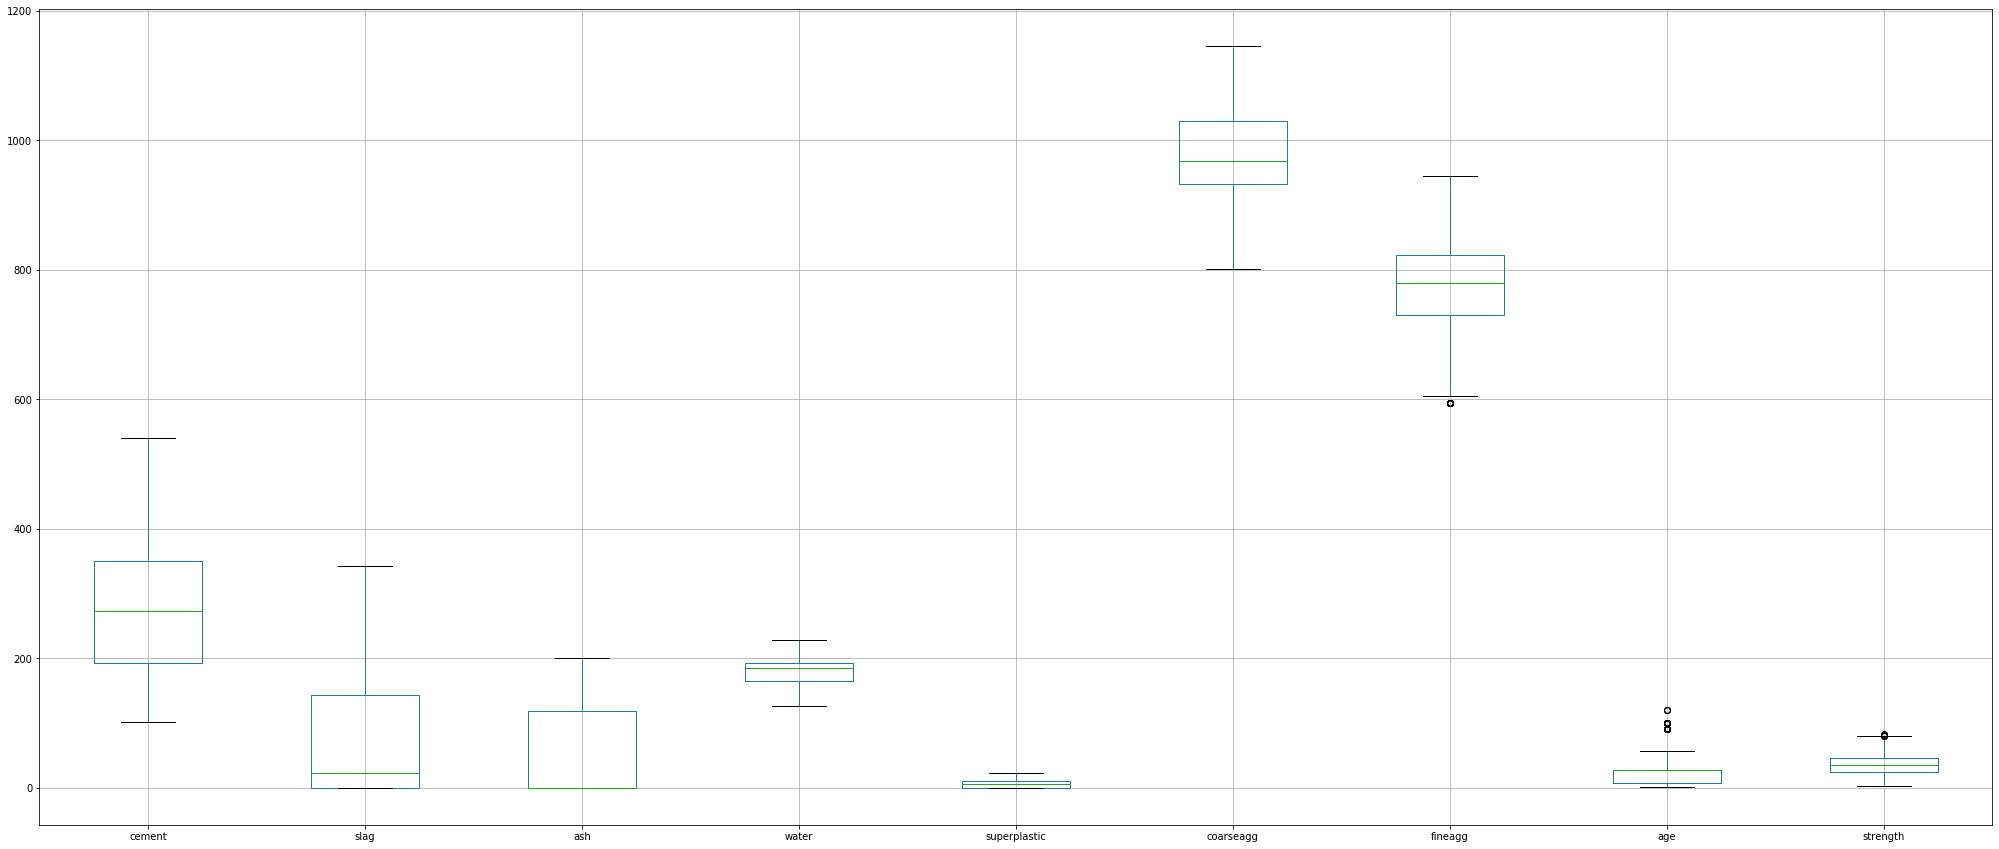

In [19]:
##Replace with median and plot after:
for col_name in df.columns[:-1]:
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3 - q1
    
    low = q1-1.5*iqr
    high = q3+1.5*iqr
    df.loc[(df[col_name] < low) | (df[col_name] > high), col_name] = df[col_name].median()
df.boxplot(figsize=(35,15))

Step 2: Bi-variate analysis between the predictor variables and between the predictor
variables and target column. Comment on your findings in terms of their
relationship and degree of relation if any. Visualize the analysis using boxplots and
pair plots, histograms or density curves. 

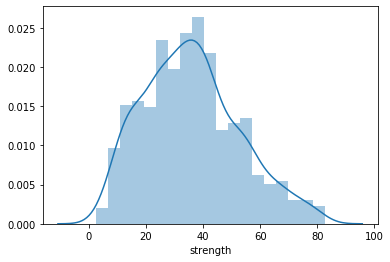

In [20]:
sns.distplot(df['strength'])

In [21]:
##Skew check:
print("Skewness = ",df['strength'].skew())

Skewness =  0.41697728841071807


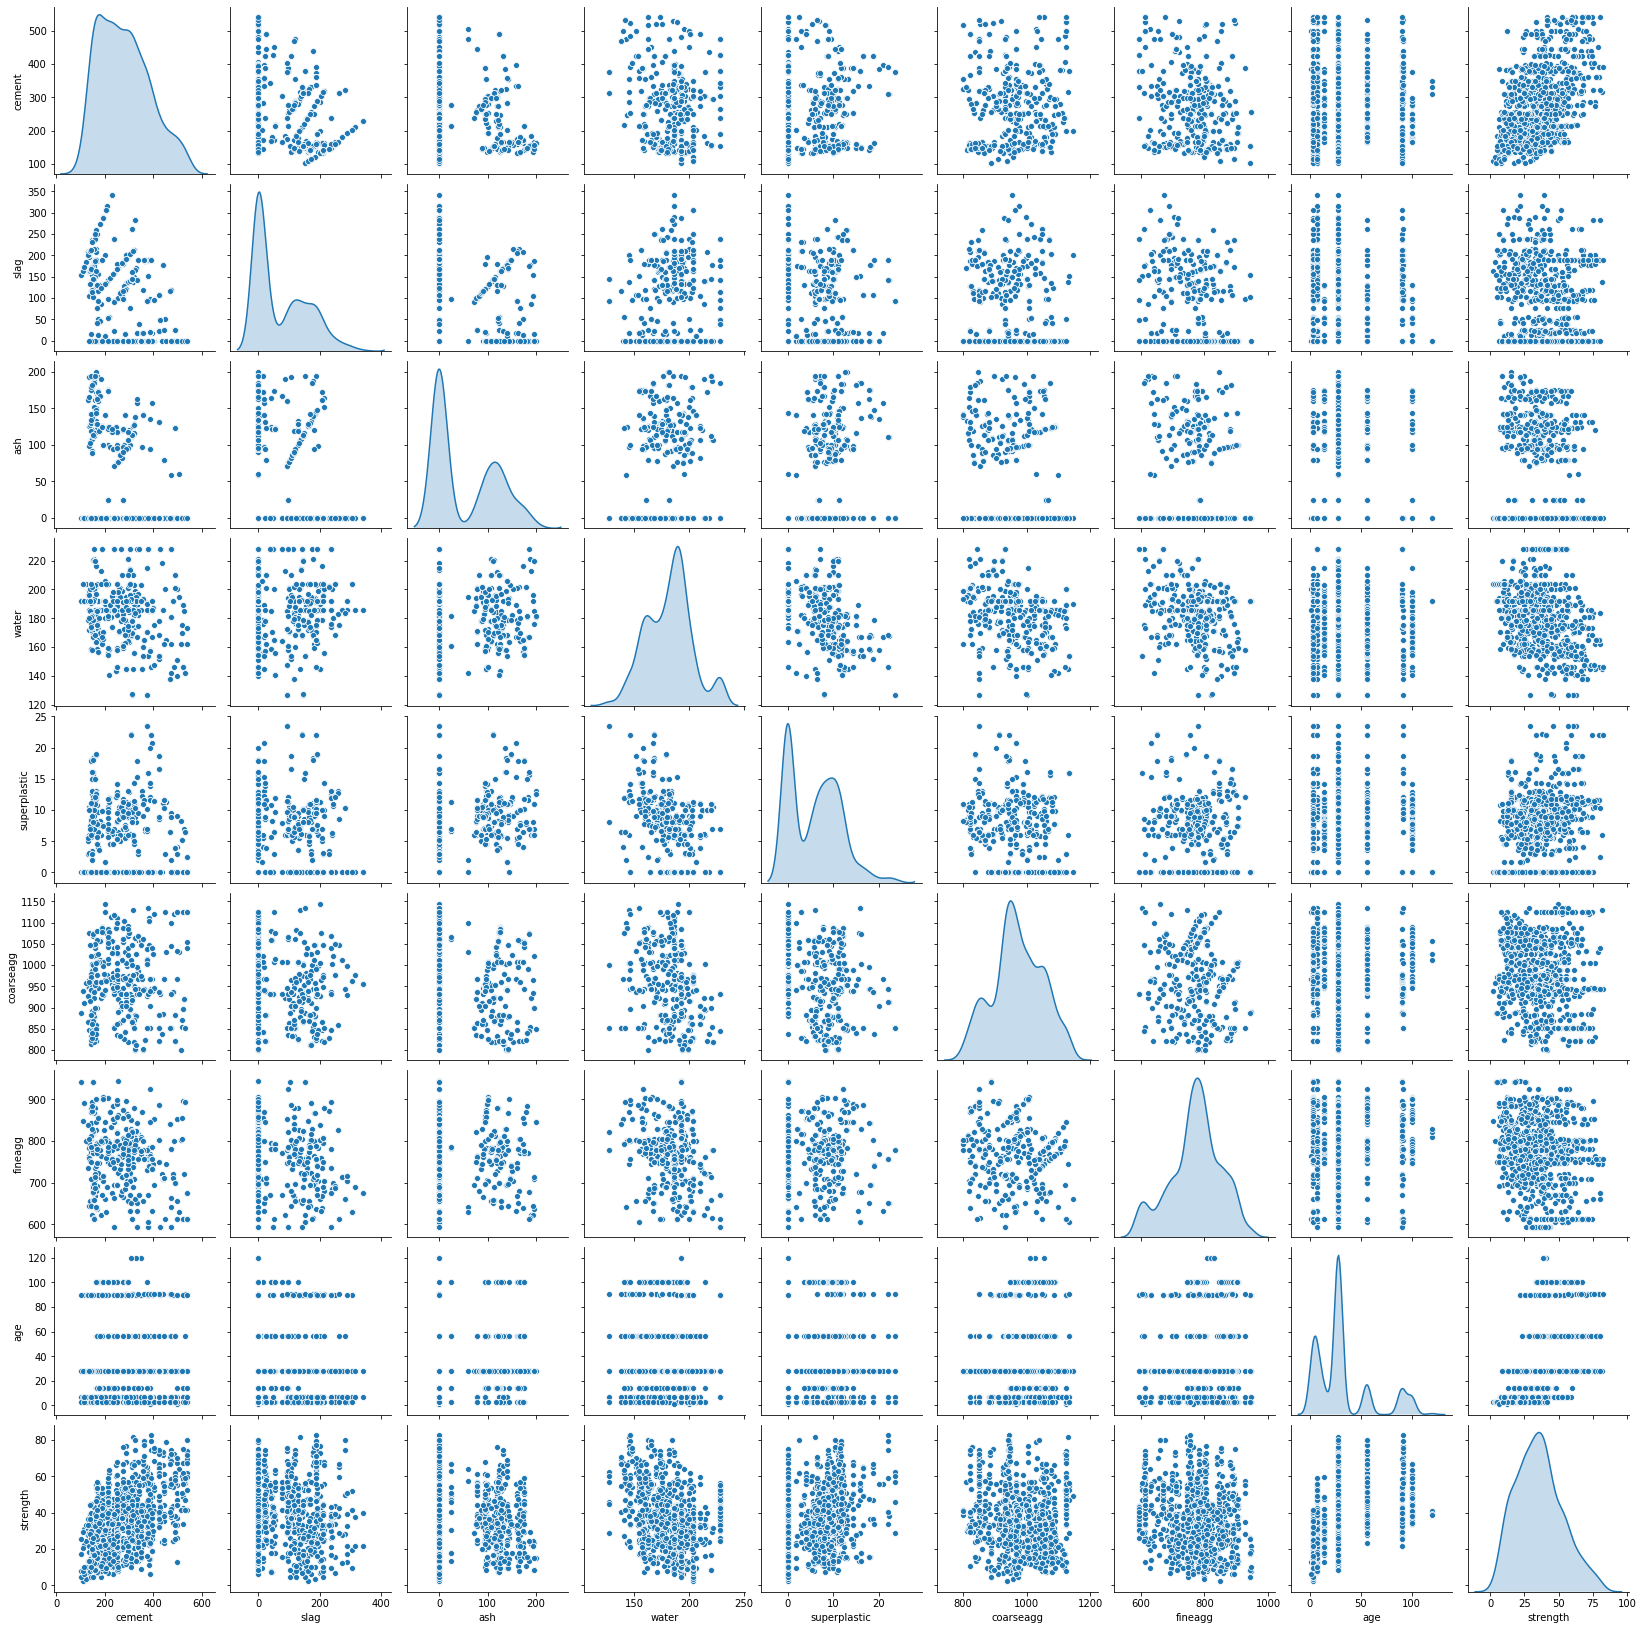

In [22]:

sns.pairplot(df, diag_kind='kde')

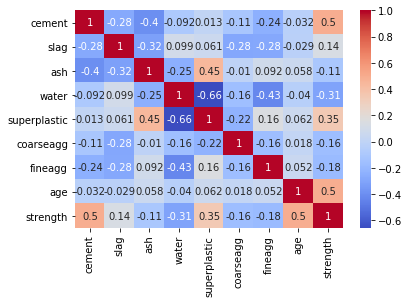

In [23]:
##Check correlations:
corr_df = df.corr()
sns.heatmap(corr_df,annot = True,cmap="coolwarm")

Observations:
    1) Cement has a high correlation with conrete strength;
    2) Superplastic and age are also highly correlated with concrete strength;
    3) Superplastic and fineagg has a high negative correlation with water

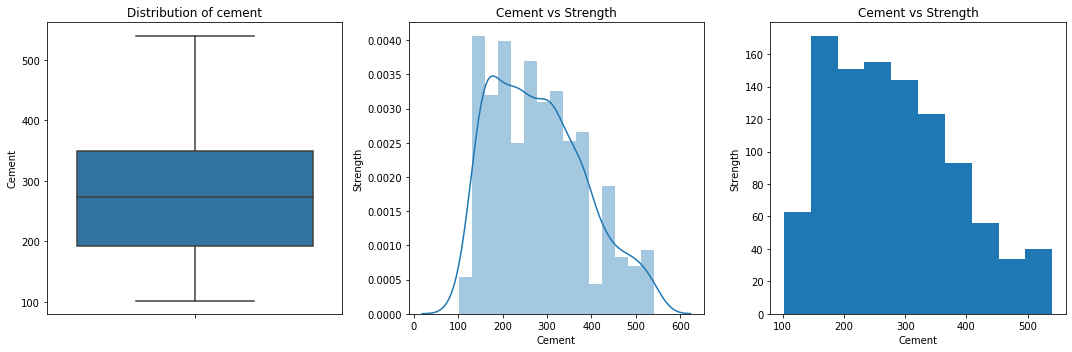

In [24]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

#boxplot
sns.boxplot(x='cement',data=df,orient='v',ax=ax1)
ax1.set_ylabel('Cement')
ax1.set_title('Distribution of cement')
ax1.tick_params(labelsize=10)

#distplot
sns.distplot(df['cement'],ax=ax2)
ax2.set_xlabel('Cement')
ax2.set_ylabel('Strength')
ax2.set_title('Cement vs Strength')
ax2.tick_params(labelsize=10)

#histogram
ax3.hist(df['cement'])
ax3.set_xlabel('Cement')
ax3.set_ylabel('Strength')
ax3.set_title('Cement vs Strength')
ax3.tick_params(labelsize=10)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()


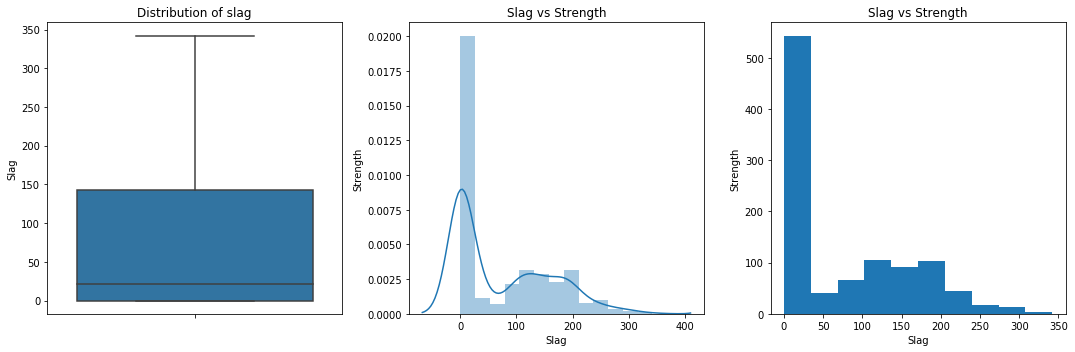

In [25]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

#boxplot
sns.boxplot(x='slag',data=df,orient='v',ax=ax1)
ax1.set_ylabel('Slag')
ax1.set_title('Distribution of slag')
ax1.tick_params(labelsize=10)

#distplot
sns.distplot(df['slag'],ax=ax2)
ax2.set_xlabel('Slag')
ax2.set_ylabel('Strength')
ax2.set_title('Slag vs Strength')
ax2.tick_params(labelsize=10)

#histogram
ax3.hist(df['slag'])
ax3.set_xlabel('Slag')
ax3.set_ylabel('Strength')
ax3.set_title('Slag vs Strength')
ax3.tick_params(labelsize=10)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

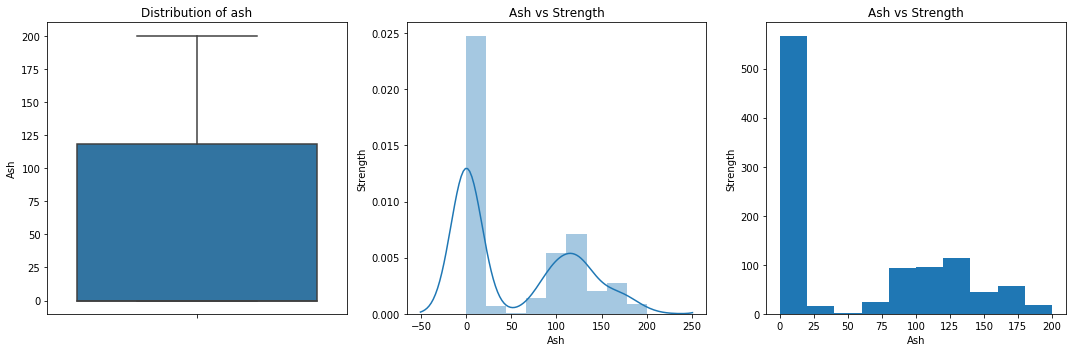

In [26]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

#boxplot
sns.boxplot(x='ash',data=df,orient='v',ax=ax1)
ax1.set_ylabel('Ash')
ax1.set_title('Distribution of ash')
ax1.tick_params(labelsize=10)

#distplot
sns.distplot(df['ash'],ax=ax2)
ax2.set_xlabel('Ash')
ax2.set_ylabel('Strength')
ax2.set_title('Ash vs Strength')
ax2.tick_params(labelsize=10)

#histogram
ax3.hist(df['ash'])
ax3.set_xlabel('Ash')
ax3.set_ylabel('Strength')
ax3.set_title('Ash vs Strength')
ax3.tick_params(labelsize=10)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()


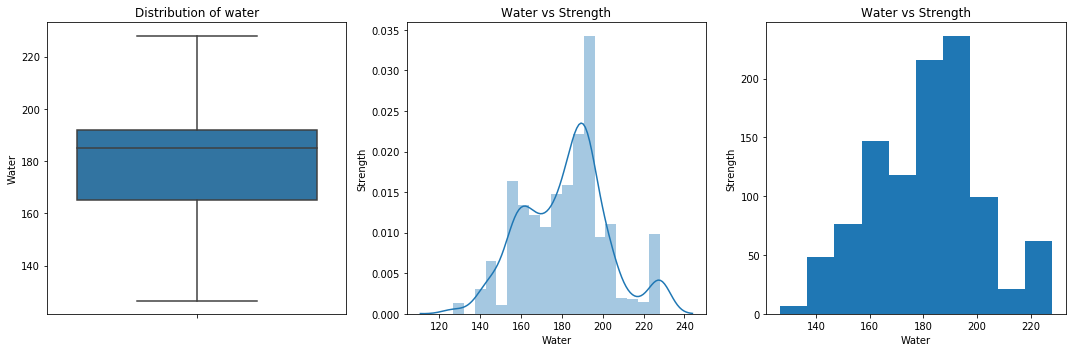

In [27]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

#boxplot
sns.boxplot(x='water',data=df,orient='v',ax=ax1)
ax1.set_ylabel('Water')
ax1.set_title('Distribution of water')
ax1.tick_params(labelsize=10)

#distplot
sns.distplot(df['water'],ax=ax2)
ax2.set_xlabel('Water')
ax2.set_ylabel('Strength')
ax2.set_title('Water vs Strength')
ax2.tick_params(labelsize=10)

#histogram
ax3.hist(df['water'])
ax3.set_xlabel('Water')
ax3.set_ylabel('Strength')
ax3.set_title('Water vs Strength')
ax3.tick_params(labelsize=10)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()


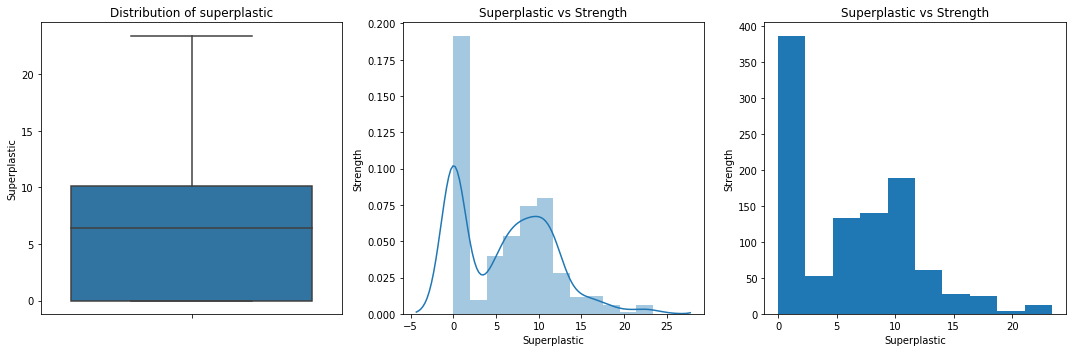

In [28]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

#boxplot
sns.boxplot(x='superplastic',data=df,orient='v',ax=ax1)
ax1.set_ylabel('Superplastic')
ax1.set_title('Distribution of superplastic')
ax1.tick_params(labelsize=10)

#distplot
sns.distplot(df['superplastic'],ax=ax2)
ax2.set_xlabel('Superplastic')
ax2.set_ylabel('Strength')
ax2.set_title('Superplastic vs Strength')
ax2.tick_params(labelsize=10)

#histogram
ax3.hist(df['superplastic'])
ax3.set_xlabel('Superplastic')
ax3.set_ylabel('Strength')
ax3.set_title('Superplastic vs Strength')
ax3.tick_params(labelsize=10)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()


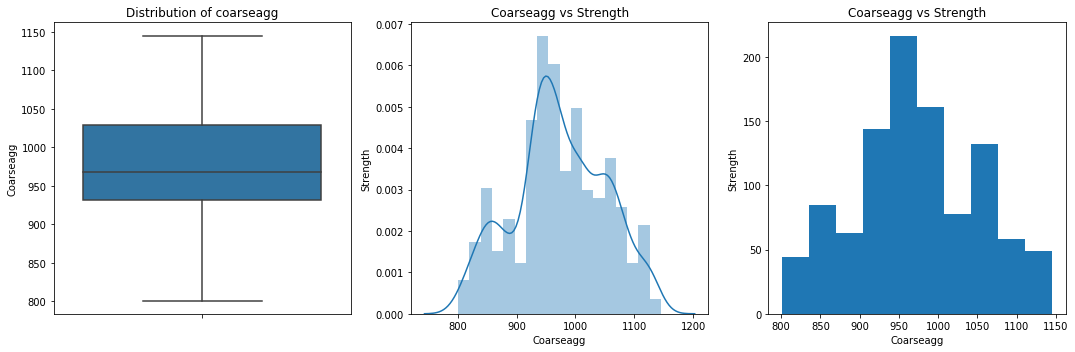

In [29]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

#boxplot
sns.boxplot(x='coarseagg',data=df,orient='v',ax=ax1)
ax1.set_ylabel('Coarseagg')
ax1.set_title('Distribution of coarseagg')
ax1.tick_params(labelsize=10)

#distplot
sns.distplot(df['coarseagg'],ax=ax2)
ax2.set_xlabel('Coarseagg')
ax2.set_ylabel('Strength')
ax2.set_title('Coarseagg vs Strength')
ax2.tick_params(labelsize=10)

#histogram
ax3.hist(df['coarseagg'])
ax3.set_xlabel('Coarseagg')
ax3.set_ylabel('Strength')
ax3.set_title('Coarseagg vs Strength')
ax3.tick_params(labelsize=10)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()


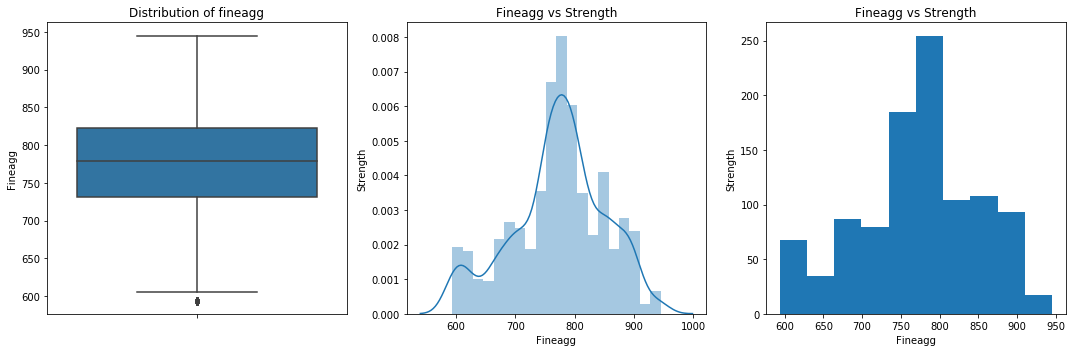

In [30]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

#boxplot
sns.boxplot(x='fineagg',data=df,orient='v',ax=ax1)
ax1.set_ylabel('Fineagg')
ax1.set_title('Distribution of fineagg')
ax1.tick_params(labelsize=10)

#distplot
sns.distplot(df['fineagg'],ax=ax2)
ax2.set_xlabel('Fineagg')
ax2.set_ylabel('Strength')
ax2.set_title('Fineagg vs Strength')
ax2.tick_params(labelsize=10)

#histogram
ax3.hist(df['fineagg'])
ax3.set_xlabel('Fineagg')
ax3.set_ylabel('Strength')
ax3.set_title('Fineagg vs Strength')
ax3.tick_params(labelsize=10)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()


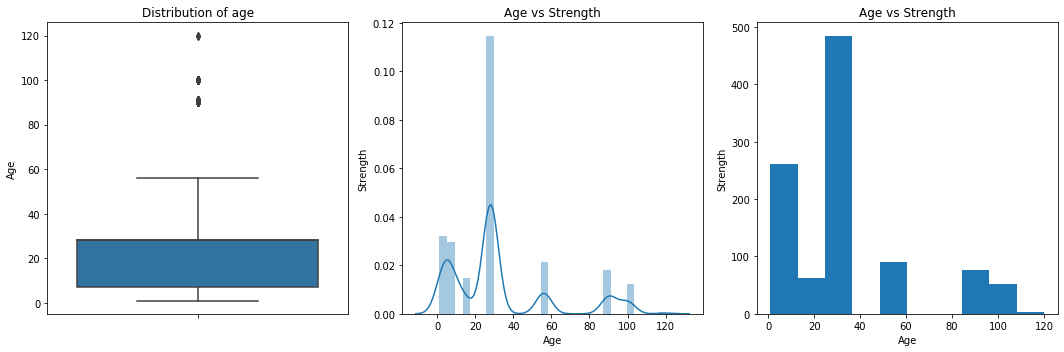

In [31]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

#boxplot
sns.boxplot(x='age',data=df,orient='v',ax=ax1)
ax1.set_ylabel('Age')
ax1.set_title('Distribution of age')
ax1.tick_params(labelsize=10)

#distplot
sns.distplot(df['age'],ax=ax2)
ax2.set_xlabel('Age')
ax2.set_ylabel('Strength')
ax2.set_title('Age vs Strength')
ax2.tick_params(labelsize=10)

#histogram
ax3.hist(df['age'])
ax3.set_xlabel('Age')
ax3.set_ylabel('Strength')
ax3.set_title('Age vs Strength')
ax3.tick_params(labelsize=10)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EDC9405108>,
      dtype=object)

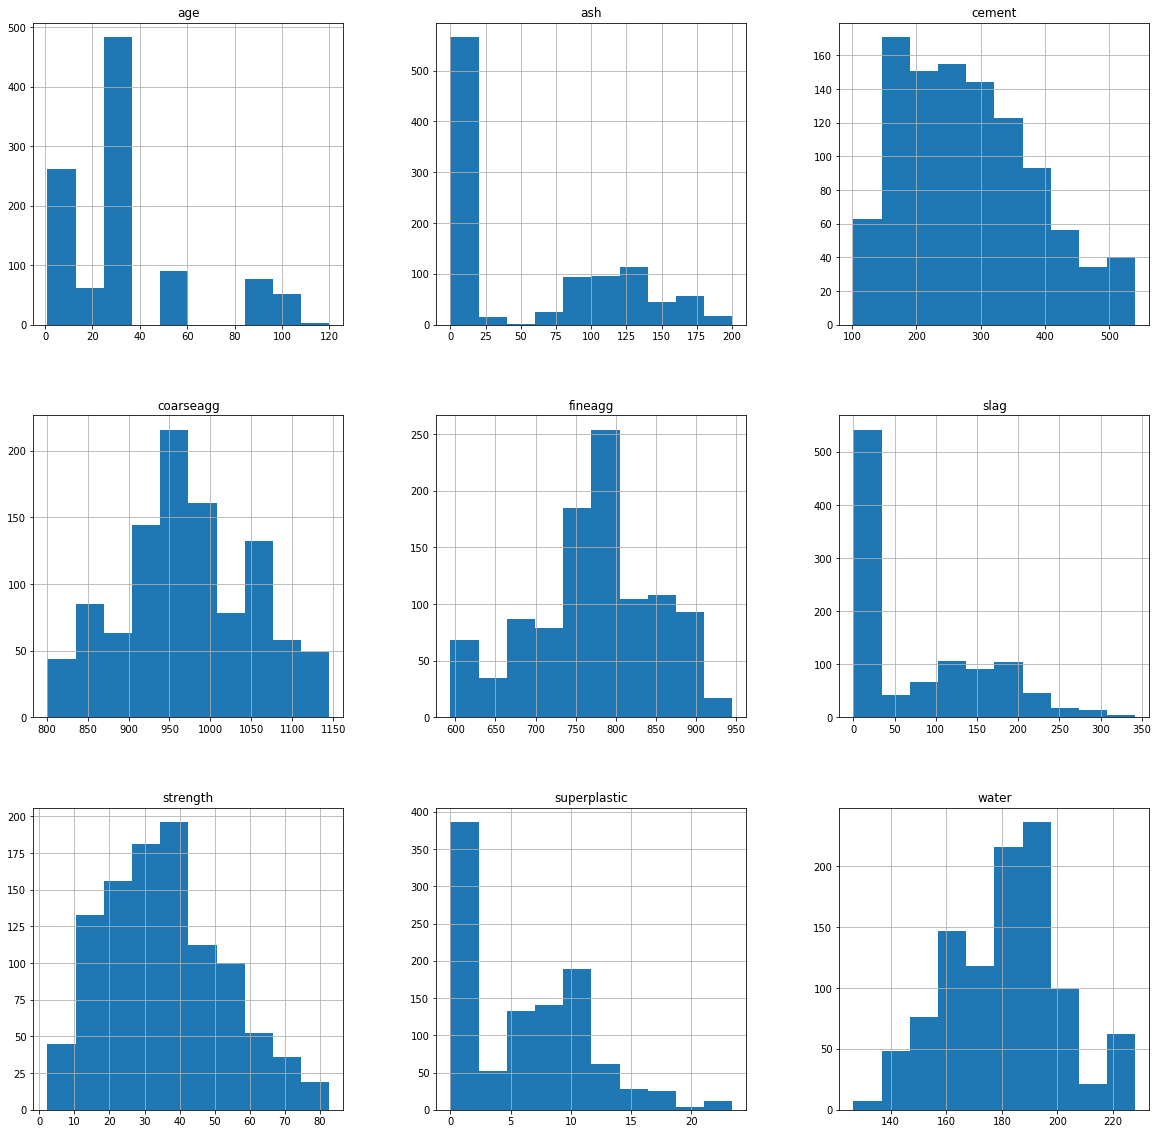

In [125]:
df.hist(figsize=(20,20))

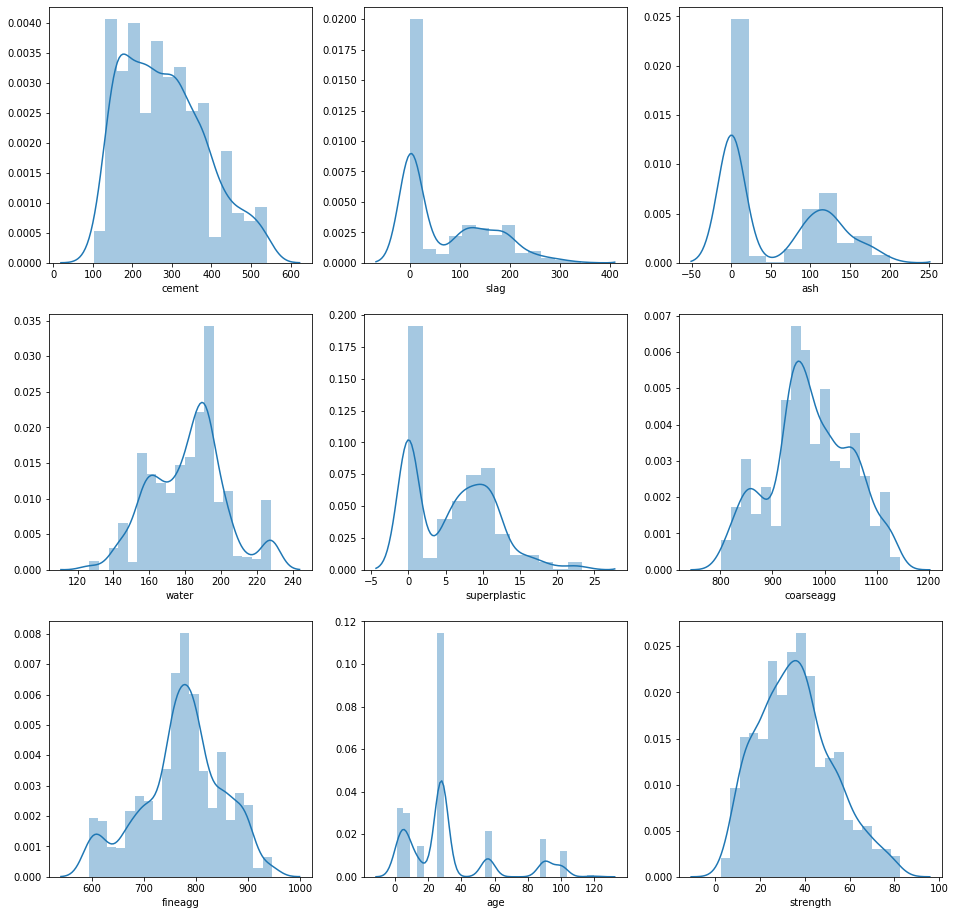

In [33]:
fig, ax2 = plt.subplots(3, 3, figsize=(16, 16))
sns.distplot(df['cement'],ax=ax2[0][0])
sns.distplot(df['slag'],ax=ax2[0][1])
sns.distplot(df['ash'],ax=ax2[0][2])
sns.distplot(df['water'],ax=ax2[1][0])
sns.distplot(df['superplastic'],ax=ax2[1][1])
sns.distplot(df['coarseagg'],ax=ax2[1][2])
sns.distplot(df['fineagg'],ax=ax2[2][0])
sns.distplot(df['age'],ax=ax2[2][1])
sns.distplot(df['strength'],ax=ax2[2][2])

Observation from distplot and histogram:
    
    Cement close to normal;
    Slag is skewed (right), has 3 gaussians;
    Ash is skewed (right), has 2 gaussians;
    Water is lightly skewed (left) - hence neg corr above, has 3 gaussians
    Superplastic is skewed (right), has 2 gaussians
    Coarseagg close to normal, has 3 gaussians
    Fineagg close to normal distribution, has 2 gaussians
    Age - skewed (right), seems like a very high correlation to strength under 50 days
    

Step 3. Feature Engineering techniques
a. Identify opportunities (if any) to extract a new feature from existing features,
drop a feature (if required)
b. Get data model ready and do a train test split.
c. Decide on complexity of the model, should it be simple linear model in terms
of parameters or would a quadratic or higher degree.

In [34]:
features = df.columns[:8]
df[features].apply(lambda x: x.corr(df['strength']))

cement          0.497832
slag            0.137800
ash            -0.105755
water          -0.307711
superplastic    0.346260
coarseagg      -0.164935
fineagg        -0.182186
age             0.499850
dtype: float64

Observation:
    Cement, age, water (reverse) and superplastic seem to be significant attributes;

In [35]:
#Scale data
df_scaled = df.apply(zscore)
df_scaled=pd.DataFrame(df_scaled,columns=df.columns)
X=df_scaled.iloc[:,0:8]
y = df_scaled.iloc[:,8]

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [37]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Once again, it seems that cement, age and water are important, howvere superplastic is not (as we thought initially)

Linear Regression will not work well, as there is no linear relationship between most variables, except for cement. However, cement, although it has a strong linear relationship, has many values for stregth (from pairplot) and thus is not a good predictor.

Step 4: Creating the model and tuning it
1. Algorithms that you think will be suitable for this project. Use Kfold Cross
Validation to evaluate model performance. Use appropriate metrics and make a
DataFrame to compare models w.r.t their metrics.
(at least 3 algorithms, one bagging and one boosting based algorithms has to be
there)
2. Techniques employed to squeeze that extra performance out of the model
without making it over fit. Use Grid Search or Random Search on any of the two
models used above. Make a DataFrame to compare models after hyperparameter
tuning and their metrics as above. 

1. In my opinion, Decision tree or Random Forest, ADA Boost or Gradient Boost and Bagging Regressors will do a good job in this case. So I am going to choose these plus KFOLD CV. 

In [38]:

y_pred = dt_model.predict(X_test)
print('DT train data performance:',dt_model.score(X_train,y_train))
print('DT test data performance:',dt_model.score(X_test,y_test))
acc_DT=metrics.r2_score(y_test, y_pred)
print('Accuracy DT: ',acc_DT)
print('MSE: ',metrics.mean_squared_error(y_test, y_pred))
#Storing accuracy results for each model for final comparison
results = pd.DataFrame({'Method':['Decision Tree'], 'Accuracy': acc_DT},index={'1'})
results = results[['Method', 'Accuracy']]
results

DT train data performance: 0.9907537218441997
DT test data performance: 0.7492146421677697
Accuracy DT:  0.7492146421677697
MSE:  0.2429162005022416


,Method,Accuracy
1,Decision Tree,0.749215


Observation: training data accuracy is much highter than testing, meaning DT model is overfitted.

In [39]:
#DT KFOLD CV
num_folds = 10
seed = 77
kfold = KFold(n_splits=num_folds)
results1 = cross_val_score(dt_model,X, y, cv=kfold)
accuracy=np.mean(abs(results1))
print('Average Accuracy: ',accuracy)
print('STD: ',results1.std())

Average Accuracy:  0.8567824851996593
STD:  0.03432377928221676


In [40]:
tempResultsDf = pd.DataFrame({'Method':['Decision Tree KFOLD CV'], 'Accuracy': [accuracy]},index={'2'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'Accuracy']]
results

,Method,Accuracy
1,Decision Tree,0.749215
2,Decision Tree KFOLD CV,0.856782


In [41]:
#Random Forest
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor)
model=RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [42]:
y_pred = model.predict(X_test)
print('RFR train data performance:',model.score(X_train,y_train))
print('RFR test data performance:',model.score(X_test,y_test))
acc_RFR=metrics.r2_score(y_test, y_pred)
print('Accuracy RFR: ',acc_RFR)
print('MSE: ',metrics.mean_squared_error(y_test, y_pred))
tempResultsDf = pd.DataFrame({'Method':['Random Forest Regressor'], 'Accuracy': [acc_RFR]},index={'3'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'Accuracy']]
results

RFR train data performance: 0.9767511721026523
RFR test data performance: 0.8629663297626526
Accuracy RFR:  0.8629663297626525
MSE:  0.13273381987955715


,Method,Accuracy
1,Decision Tree,0.749215
2,Decision Tree KFOLD CV,0.856782
3,Random Forest Regressor,0.862966


Observation: RFR model is still overfitted... 97% in training vs 90% in testing data environment

In [43]:
#KFOLD CV:
num_folds = 10
seed = 77
kfold = KFold(n_splits=num_folds)
results1 = cross_val_score(model,X, y, cv=kfold)
accuracy=np.mean(abs(results1))
print('Average accuracy: ',accuracy)
print('STD: ',results1.std())

Average accuracy:  0.9108134188180228
STD:  0.02362372529418895


In [44]:
tempResultsDf = pd.DataFrame({'Method':['Random Forest Regressor KFOLD CV'], 'Accuracy': [accuracy]},index={'4'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'Accuracy']]
results

,Method,Accuracy
1,Decision Tree,0.749215
2,Decision Tree KFOLD CV,0.856782
3,Random Forest Regressor,0.862966
4,Random Forest Regressor KFOLD CV,0.910813


In [45]:
#Gradient Boost Regression model:
model=GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [46]:
y_pred = model.predict(X_test)
print('GBR train data performance:',model.score(X_train,y_train))
print('GBR test data performance:',model.score(X_test,y_test))
acc_GBR=metrics.r2_score(y_test, y_pred)
print('Accuracy GBR: ',acc_GBR)
print('MSE: ',metrics.mean_squared_error(y_test, y_pred))
tempResultsDf = pd.DataFrame({'Method':['Gradient Boost Regressor'], 'Accuracy': [acc_GBR]},index={'5'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'Accuracy']]
results

GBR train data performance: 0.9493586525216526
GBR test data performance: 0.881735762114246
Accuracy GBR:  0.881735762114246
MSE:  0.11455333585192481


,Method,Accuracy
1,Decision Tree,0.749215
2,Decision Tree KFOLD CV,0.856782
3,Random Forest Regressor,0.862966
4,Random Forest Regressor KFOLD CV,0.910813
5,Gradient Boost Regressor,0.881736


In [47]:
#KFOLD CV:
num_folds = 10
seed = 77
kfold = KFold(n_splits=num_folds)
results1 = cross_val_score(model,X, y, cv=kfold)
accuracy=np.mean(abs(results1))
print('Average accuracy: ',accuracy)
print('STD: ',results1.std())

Average accuracy:  0.8994212264348121
STD:  0.017093300485717135


In [48]:
tempResultsDf = pd.DataFrame({'Method':['Gradient Boost Regressor KFOLD CV'], 'Accuracy': [accuracy]},index={'6'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'Accuracy']]
results

,Method,Accuracy
1,Decision Tree,0.749215
2,Decision Tree KFOLD CV,0.856782
3,Random Forest Regressor,0.862966
4,Random Forest Regressor KFOLD CV,0.910813
5,Gradient Boost Regressor,0.881736
6,Gradient Boost Regressor KFOLD CV,0.899421


In [49]:
#Bagging Regressor:
model=BaggingRegressor()
model.fit(X_train, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [50]:
y_pred = model.predict(X_test)
print('BR train data performance:',model.score(X_train,y_train))
print('BR test data performance:',model.score(X_test,y_test))
acc_BR=metrics.r2_score(y_test, y_pred)
print('Accuracy BR: ',acc_BR)
print('MSE: ',metrics.mean_squared_error(y_test, y_pred))
tempResultsDf = pd.DataFrame({'Method':['Bagging Regressor'], 'Accuracy': [acc_BR]},index={'7'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'Accuracy']]
results

BR train data performance: 0.9670767447669588
BR test data performance: 0.8503864661988568
Accuracy BR:  0.8503864661988568
MSE:  0.1449189517635252


,Method,Accuracy
1,Decision Tree,0.749215
2,Decision Tree KFOLD CV,0.856782
3,Random Forest Regressor,0.862966
4,Random Forest Regressor KFOLD CV,0.910813
5,Gradient Boost Regressor,0.881736
6,Gradient Boost Regressor KFOLD CV,0.899421
7,Bagging Regressor,0.850386


In [51]:
#KFOLD CV:
num_folds = 10
seed = 77
kfold = KFold(n_splits=num_folds)
results1 = cross_val_score(model,X, y, cv=kfold)
accuracy=np.mean(abs(results1))
print('Average accuracy: ',accuracy)
print('STD: ',results1.std())
tempResultsDf = pd.DataFrame({'Method':['Bagging Regressor KFOLD CV'], 'Accuracy': [accuracy]},index={'8'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'Accuracy']]
results

Average accuracy:  0.8961928420726682
STD:  0.032803630483332354


,Method,Accuracy
1,Decision Tree,0.749215
2,Decision Tree KFOLD CV,0.856782
3,Random Forest Regressor,0.862966
4,Random Forest Regressor KFOLD CV,0.910813
5,Gradient Boost Regressor,0.881736
6,Gradient Boost Regressor KFOLD CV,0.899421
7,Bagging Regressor,0.850386
8,Bagging Regressor KFOLD CV,0.896193


In [71]:
#RandomizedSearchCV on Random Forest
from sklearn.model_selection import RandomizedSearchCV

In [72]:
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint

In [73]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [85]:

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [116]:
print("R^2 Score of Random Forest with tuned parameters with RandomizedSearchCV: {}".format(round(r2_score(y_test, rf_random.predict(X_test)), 6)))
acc_RFR_RS=format(round(r2_score(y_test, rf_random.predict(X_test)), 6))

R^2 Score of Random Forest with tuned parameters with RandomizedSearchCV: 0.86821


In [117]:
tempResultsDf = pd.DataFrame({'Method':['Random Search - Random Forest'], 'Accuracy': [acc_RFR_RS]},index={'9'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'Accuracy']]
results

,Method,Accuracy
1,Decision Tree,0.749215
2,Decision Tree KFOLD CV,0.856782
3,Random Forest Regressor,0.862966
4,Random Forest Regressor KFOLD CV,0.910813
5,Gradient Boost Regressor,0.881736
6,Gradient Boost Regressor KFOLD CV,0.899421
7,Bagging Regressor,0.850386
8,Bagging Regressor KFOLD CV,0.896193
8,Bagging Regressor KFOLD CV,0.896193
9,Random Search - Random Forest,0.86821


In [107]:
gbr = GradientBoostingRegressor(random_state = 42)


In [108]:
learning_rate = [0.1,0.01,0.02,0.05]
max_features = [1,0.3,0.1]
max_depth = [4,6]
max_depth.append(None)
min_samples_leaf = [3,5,9]

random_grid = {'learning_rate': learning_rate,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

In [109]:

gbr_random = RandomizedSearchCV(estimator = gbr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
gbr_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   12.4s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                             

In [114]:
print("R^2 Score of Gradient Boosting Regressor with tuned parameters with Randomized Search: {}".format(round(r2_score(y_test, gbr_random.predict(X_test)), 6)))
acc_GBR_RS=format(round(r2_score(y_test, gbr_random.predict(X_test)), 6))

R^2 Score of Gradient Boosting Regressor with tuned parameters with Randomized Search: 0.905659


In [112]:
tempResultsDf = pd.DataFrame({'Method':['Random Search - Gradient Boosting Regressor'], 'Accuracy': [acc_GBR_RS]},index={'10'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'Accuracy']]
results

,Method,Accuracy
1,Decision Tree,0.749215
2,Decision Tree KFOLD CV,0.856782
3,Random Forest Regressor,0.862966
4,Random Forest Regressor KFOLD CV,0.910813
5,Gradient Boost Regressor,0.881736
6,Gradient Boost Regressor KFOLD CV,0.899421
7,Bagging Regressor,0.850386
8,Bagging Regressor KFOLD CV,0.896193
8,Bagging Regressor KFOLD CV,0.896193
9,Random Search - Random Forest,0.86821


In [122]:
I1=0.86821-0.862966
print('Improvement due to fine tuning Random Forest hyperparameters',I1)

Improvement due to fine tuning Random Forest hyperparameters 0.04269299999999998


In [124]:
I2=0.905659-0.881736
print('Improvement due to fine tuning Random Forest hyperparameters',I2)

Improvement due to fine tuning Random Forest hyperparameters 0.023923000000000028
